In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import pandas as pd
from pylab import *
from matplotlib import pyplot

In [4]:
#changement du dossier par défaut
import os
os.chdir("/Users/guillaume/Desktop/MVA cours/PGM/data")

In [5]:
#chargement des données
testA = np.asarray(pandas.read_table("testA.txt",sep=" ",header=0))
testB = np.asarray(pandas.read_table("testB.txt",sep=" ",header=0))
testC = np.asarray(pandas.read_table("testC.txt",sep=" ",header=0))
trainA = np.asarray(pandas.read_table("trainA.txt",sep=" ",header=0))
trainB = np.asarray(pandas.read_table("trainB.txt",sep=" ",header=0))
trainC = np.asarray(pandas.read_table("trainC.txt",sep=" ",header=0))


In [6]:
#données training
X = trainA[:,0:2]
y = trainA[:,2]

X_B = trainB[:,0:2]
y_B = trainB[:,2]

X_C = trainC[:,0:2]
y_C = trainC[:,2]

#données test
X_test_A = testA[:,0:2]
y_test_A = testA[:,2]

X_test_B = testB[:,0:2]
y_test_B = testB[:,2]

X_test_C = testC[:,0:2]
y_test_C = testC[:,2]


In [7]:
#fonctions utilisées
def sigmoid(x):
        return(1/(1+np.exp(-x)))

#fonction erreur
def error(y, y_pred):
    error = sum((y-y_pred)**2) / len(y)
    return(error)



In [49]:
#Generative model LDA

# paramètres
def LDA(X, y, X_test, y_test, s, plot = True):  #s correspond au nom du jeu et plot au jeu qu'on veut plot (train ou test => True on plot le test)

    if plot == True:
        plotX = X_test
        ploty = y_test
    else :
        plotX = X
        ploty = y
        

    #paramètre pi
    pi = mean(y)

    #mu1
    mu1 = np.dot(X.T, y) / sum(y)

    #mu0
    mu0 = np.dot(X.T, 1-y) / sum(1-y)
    
    #sigma
    A0 = np.zeros((2,2))
    A1 = np.zeros((2,2))
    for i in range(len(y)):
        if y[i]==1:
            A1 += ((X[i,:] - mu1)[:,np.newaxis].dot((X[i,:] - mu1)[:,np.newaxis].T))
        else:
            A0 += ((X[i,:] - mu0)[:,np.newaxis].dot((X[i,:] - mu0)[:,np.newaxis].T))
        
    sigma = (A0 + A1) / len(y)
    
    #prédiction
    w = np.dot(np.linalg.inv(sigma) , (mu1 - mu0))
    b = .5*(np.dot(mu0.T, np.dot(np.linalg.inv(sigma), mu0)) - np.dot(mu1.T, np.dot(np.linalg.inv(sigma), mu1))) + np.log(pi / (1-pi))
    y_pred = np.where(plotX.dot(w) + b > 0, 1, 0)
    
    #erreur
    err = error(ploty, y_pred)
    
    #plot 
    #on récupère les x en fonction de leur label
    x1 = plotX[np.where(ploty==1)[0],0:2]    
    x0 = plotX[np.where(ploty==0)[0], 0:2]
    plt.scatter(x1[:,0], x1[:,1], c="coral", label = "y = 1")
    plt.scatter(x0[:,0], x0[:,1], c="blue", label = "y = 0" )
    plt.title('LDA pour le jeu' + str(s) )
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    #print de p(y=1 \ x) = 0.5
    x , o = np.meshgrid(linspace(plotX[:,0].min()-2, plotX[:,0].max()+2, 100), linspace(plotX[:,1].min()-2, plotX[:,1].max()+2, 100))
    z = b + w[0]*x + o*w[1]
    contour(x, o, z, [0])
    plt.contourf(x, o, z, 0, cmap = plt.cm.magma, alpha = 0.5)
    plt.legend()
    return([pi, mu0, mu1, sigma], err)
    

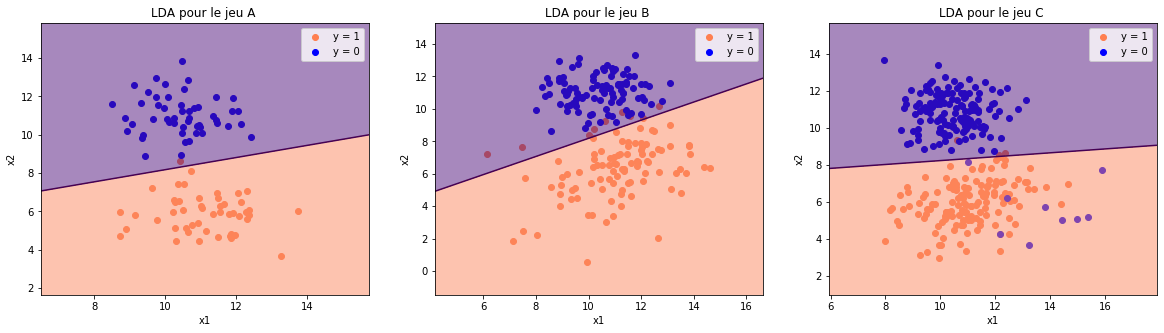

In [50]:
figure = pyplot.figure(figsize = (20, 5))
subplot(1,3,1)
partestA, errtestA = LDA(X, y, X_test_A, y_test_A, " A ")
subplot(1,3,2)
partestB, errtestB = LDA(X_B, y_B, X_test_B, y_test_B, " B ")
subplot(1,3,3)
partestC, errtestC = LDA(X_C, y_C, X_test_C, y_test_C, " C ")

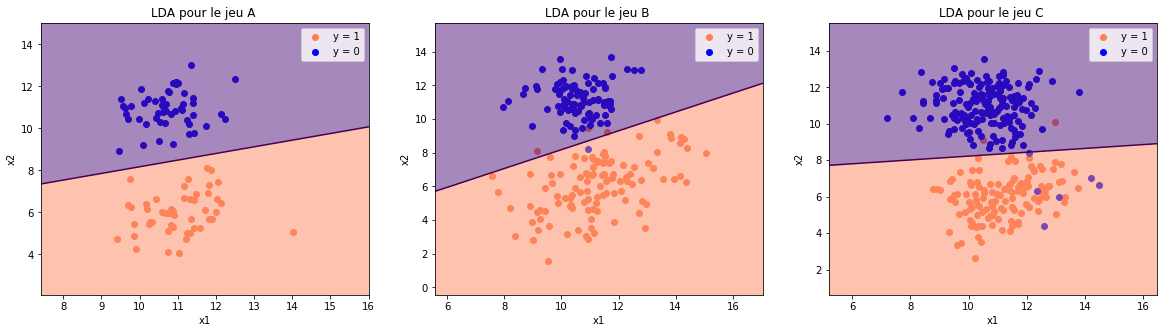

In [51]:
figure = pyplot.figure(figsize = (20, 5))
subplot(1,3,1)
partrainA, errtrainA = LDA(X, y, X, y, " A ", False)
subplot(1,3,2)
partrainB, errtrainB = LDA(X_B, y_B, X_B, y_B, " B ", False)
subplot(1,3,3)
partrainC, errtrainC = LDA(X_C, y_C, X_C, y_C, " C ", False)

errLDA =[errtestA, errtestB, errtestC, errtrainA, errtrainB, errtrainC]
errLDA = [i * 100 for i in errLDA]

In [53]:
def loglike(X, y , w):
    X = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
    return np.dot(y.T, np.log(sigmoid(np.dot(X , w)))) + np.dot((1-y).T,np.log(sigmoid(-np.dot(X , w))))




def Logistic(X, y, w , X_test, y_test,  s, plot = True, tol=.00001 , n =10000):
    
    if plot == True:
        plotX = X_test
        ploty = y_test
    else :
        plotX = X
        ploty = y
        
        
    Xf = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
    
    for i in range(n):
        eta = sigmoid(Xf.dot(w))
         
            
        #grad/hess wrt w
        grad_w = Xf.T.dot(y - eta)
        hess_w = -np.dot( np.dot(Xf.T , np.diagflat(eta*(1-eta))) , Xf)


        #update
        temp_w = w - np.linalg.inv(hess_w).dot(grad_w)
        
        if np.abs(loglike(X , y , w) - loglike(X , y , temp_w)) < tol:
            break
            
        w = temp_w
    
    
    #prédiction
    Xtilde = np.concatenate((np.ones((plotX.shape[0],1)), plotX), axis=1)
    y_pred = np.where(Xtilde.dot(w) > 0, 1, 0)
    
    #erreur
    err = error(ploty, y_pred)
    
    
    #plot
    x1 = plotX[np.where(ploty==1)[0],0:2]    
    x0 = plotX[np.where(ploty==0)[0], 0:2]
    plt.scatter(x1[:,0], x1[:,1], c="coral", label = "y = 1")
    plt.scatter(x0[:,0], x0[:,1], c="blue", label = "y = 0" )
    plt.title('Régression logistique pour le jeu' + str(s))
    plt.xlabel('x1')
    plt.ylabel('x2')

    x , o = np.meshgrid(linspace(plotX[:,0].min()-2, plotX[:,0].max()+2, 100), linspace(plotX[:,1].min()-2, plotX[:,1].max()+2, 100))
    z = w[0] + w[1]*x + o*w[2]
    contour(x, o, z, [0])
    contourf(x, o, z, 0, cmap = plt.cm.magma, alpha = 0.5)
    plt.legend()
    return(w, err)

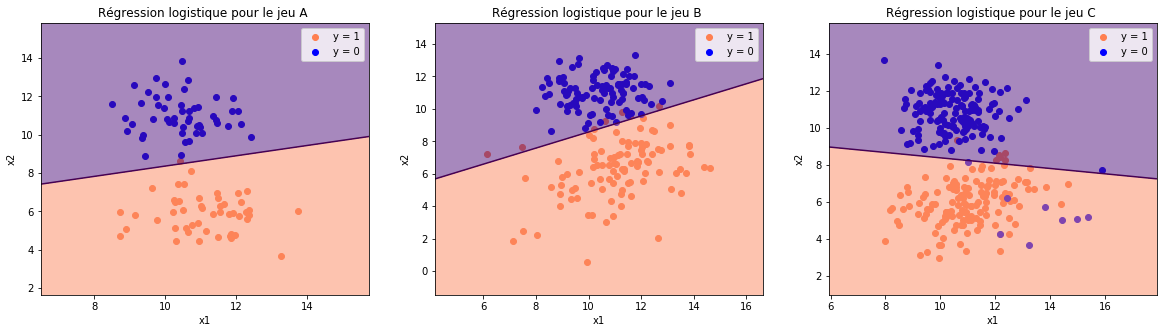

In [64]:
figure = pyplot.figure(figsize = (20, 5))
subplot(1,3,1)
wA, errtestA = Logistic(X, y, array([.01, .02, .03]), X_test_A, y_test_A, " A ")
subplot(1,3,2)
wB, errtestB = Logistic(X_B, y_B, array([.01, .02, .03]), X_test_B, y_test_B, " B ")
subplot(1,3,3)
wC, errtestC = Logistic(X_C, y_C, array([.01, .02, .03]), X_test_C, y_test_C, " C ")

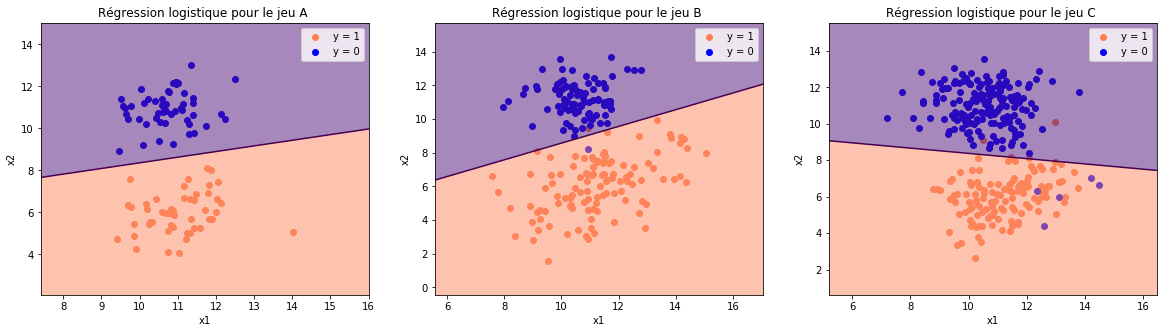

In [55]:
figure = pyplot.figure(figsize = (20, 5))
subplot(1,3,1)
wA, errtrainA = Logistic(X, y, array([.01, .02, .03]), X, y, " A ", False)
subplot(1,3,2)
wB, errtrainB = Logistic(X_B, y_B, array([.01, .02, .03]), X_B, y_B, " B ", False)
subplot(1,3,3)
wC, errtrainC = Logistic(X_C, y_C, array([.01, .02, .03]), X_C, y_C, " C ", False)

errlog = [errtestA, errtestB, errtestC, errtrainA, errtrainB, errtrainC]
errlog = [i *100 for i in errlog]

In [65]:
def reglin(X, y, X_test, y_test, s, plot = True):
    
    if plot == True:
        plotX = X_test
        ploty = y_test
    else :
        plotX = X
        ploty = y
        
        
    #on définit le x avec l'intercept
    Xtilde = np.concatenate((np.ones((len(y),1)), X), axis=1)
    
    #on trouve les poids
    poids = np.dot(np.dot(np.linalg.inv(np.dot(Xtilde.T,Xtilde)),Xtilde.T),y)
    sigma = (y-Xtilde.dot(poids)).T.dot(y - Xtilde.dot(poids)) / len(y)

    
    #prédiction
    Xbis = np.concatenate((np.ones((plotX.shape[0],1)), plotX), axis=1)
    g = np.sqrt(sigma * np.log(2 / (np.pi * sigma)))
    y_pred = np.where(np.abs(1 - Xbis.dot(poids)) < g , 1, 0)

    #erreur
    err = error(ploty, y_pred)

    #plot
    x1 = plotX[np.where(ploty==1)[0],0:2]    
    x0 = plotX[np.where(ploty==0)[0], 0:2]
    plt.scatter(x1[:,0], x1[:,1], c = "coral", label = "y = 1")
    plt.scatter(x0[:,0], x0[:,1], c = "blue", label = "y = 0" )
    plt.title('Régression Linéaire pour le jeu' + str(s))
    plt.xlabel('x1')
    plt.ylabel('x2')

    x , o = np.meshgrid(linspace(plotX[:,0].min()-2, plotX[:,0].max()+2, 100), linspace(plotX[:,1].min()-2, plotX[:,1].max()+2, 100))
    a = sigma * np.log(2/(np.pi * sigma))
    z = (1 - poids[0] - poids[1]*x - poids[2]*o)**2
    contour(x, o, z, [a])
    contourf(x, o, z, [-a,0,a], cmap = plt.cm.magma, alpha = 0.5)
    plt.legend()
    return([poids, sigma], err)  

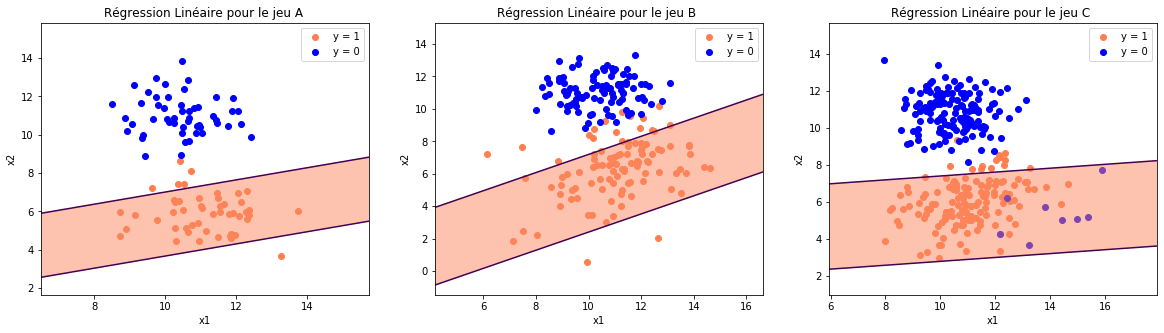

In [66]:
figure = pyplot.figure(figsize = (20, 5))
subplot(1,3,1)
paramA , errtestA = reglin(X, y, X_test_A, y_test_A, " A ")
subplot(1,3,2)
paramB , errtestB = reglin(X_B, y_B, X_test_B, y_test_B, " B ")
subplot(1,3,3), 
paramC , errtestC = reglin(X_C, y_C, X_test_C, y_test_C, " C ")

[6.0, 9.5, 7.000000000000001, 4.0, 7.000000000000001, 6.666666666666667]


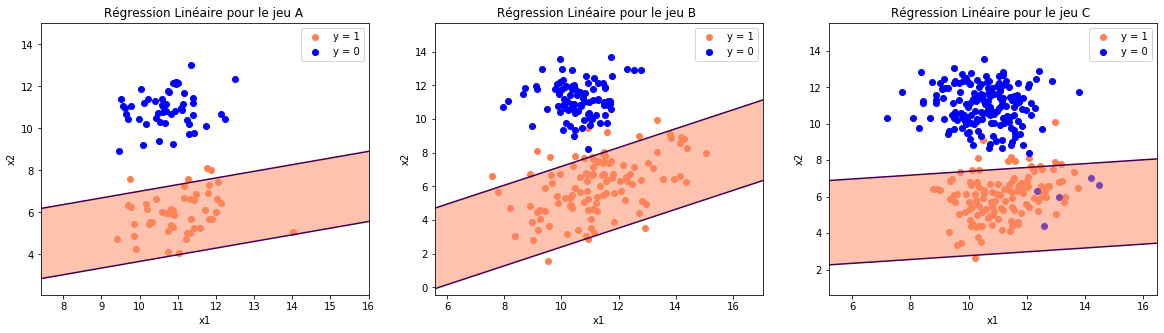

In [41]:
figure = pyplot.figure(figsize = (20, 5))
subplot(1,3,1)
paramA , errtrainA = reglin(X, y, X, y, " A ", False)
subplot(1,3,2)
paramB , errtrainB = reglin(X_B, y_B, X_B, y_B, " B ", False)
subplot(1,3,3), 
paramC , errtrainC = reglin(X_C, y_C, X_C, y_C, " C ", False)

errlin = [errtestA, errtestB, errtestC, errtrainA, errtrainB, errtrainC]
errlin = [i * 100 for i in errlin]

In [17]:
data_set =['test_A' , 'test_B' , 'test_C' , 'train_A' , 'train_B' , 'train_C']

pd.DataFrame({'Data Set': data_set , 'Erreur LDA': errLDA, 'Erreur Logistique': errlog ,'Erreur Linéaire': errlin })


,Data Set,Erreur LDA,Erreur Logistique,Erreur Linéaire
0,test_A,1.000000,1.000000,6.000000
1,test_B,4.500000,3.500000,9.500000
2,test_C,4.000000,4.666667,7.000000
3,train_A,0.000000,0.000000,4.000000
4,train_B,2.000000,1.000000,7.000000
5,train_C,2.666667,3.000000,6.666667


In [73]:
#QDA
def QDA(X, y, X_test, y_test, s, plot = True):
    
    if plot == True:
        plotX = X_test
        ploty = y_test
    else :
        plotX = X
        ploty = y
        

    #paramètre pi
    pi = mean(y)

    #mu1
    mu1 = np.dot(X.T, y) / sum(y)

    #mu0
    mu0 = np.dot(X.T, 1-y) / sum(1-y)
    
    #sigma
    A0 = np.zeros((2,2))
    A1 = np.zeros((2,2))
    for i in range(len(y)):
        if y[i]==1:
            A1 += ((X[i,:] - mu1)[:,np.newaxis].dot((X[i,:] - mu1)[:,np.newaxis].T))
        else:
            A0 += ((X[i,:] - mu0)[:,np.newaxis].dot((X[i,:] - mu0)[:,np.newaxis].T))
        
    sigma1 =  A1 / sum(y)
    sigma0 = A0 / sum(1-y)
    #erreur
    
    #p(y=1 \ x)
    
    d = .5 * (np.linalg.inv(sigma0) - np.linalg.inv(sigma1))
    
    w = np.dot(np.linalg.inv(sigma1) , mu1) - np.dot(np.linalg.inv(sigma0) , mu0)
    
    b = .5*(np.dot(mu0.T, np.dot(np.linalg.inv(sigma0), mu0)) - np.dot(mu1.T, np.dot(np.linalg.inv(sigma1), mu1))) + np.log(pi / (1-pi)) + .5*np.log(np.linalg.det(sigma0)/np.linalg.det(sigma1))
    
    y_pred = np.where((np.dot(plotX , np.dot(d , plotX.T))).diagonal() + np.dot(plotX,w) +b > 0, 1, 0)
    
    #erreur
    err = error(ploty, y_pred)
    
    
    #plot 
    #on récupère les x en fonction de leur label
    x1 = plotX[np.where(ploty==1)[0],0:2]    
    x0 = plotX[np.where(ploty==0)[0], 0:2]
    plt.scatter(x1[:,0], x1[:,1], c="coral", label = "y = 1")
    plt.scatter(x0[:,0], x0[:,1], c="blue", label = "y = 0" )
    plt.title('QDA pour le jeu' + str(s))
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    #print de p(y=1 \ x) = 0.5
    x , o = np.meshgrid(linspace(plotX[:,0].min()-2, plotX[:,0].max()+2, 100), linspace(plotX[:,1].min()-2, plotX[:,1].max()+2, 100))
    z = b + w[0]*x + o*w[1] +d[0 ,0]*(x**2) +d[0,1]*x*o + d[1,0]*x*o + d[1,1]*(o**2)
    contour(x, o, z, [0])
    contourf(x, o, z, 0, cmap = plt.cm.magma, alpha = 0.5)
    plt.legend()
    
    return([pi, mu0, mu1, sigma0, sigma1], err)

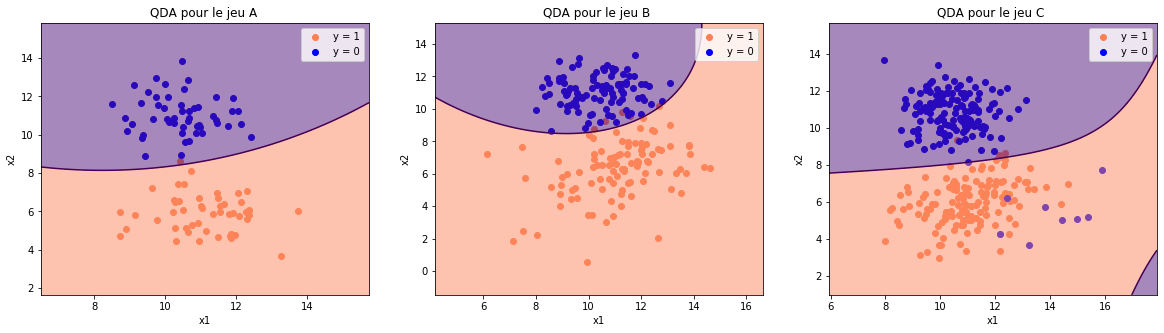

In [74]:
figure = pyplot.figure(figsize = (20, 5))
subplot(1,3,1)
parA, errtestA  = QDA(X, y, X_test_A, y_test_A, " A ")
subplot(1,3,2)
parB, errtestB = QDA(X_B, y_B, X_test_B, y_test_B, " B ")
subplot(1,3,3)
parC, errtestC  = QDA(X_C, y_C, X_test_C, y_test_C, " C ")



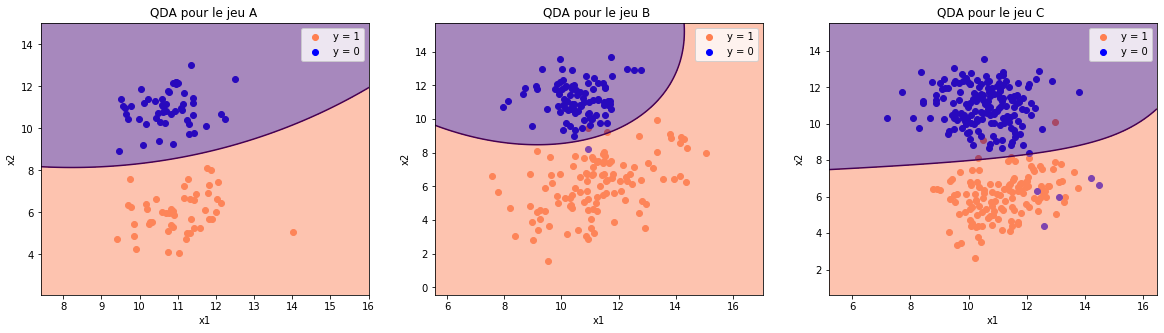

In [47]:
figure = pyplot.figure(figsize = (20, 5))
subplot(1,3,1)
parA, errtrainA  = QDA(X, y, X_test_A, y_test_A, " A ", False)
subplot(1,3,2)
parB, errtrainB = QDA(X_B, y_B, X_test_B, y_test_B, " B ", False)
subplot(1,3,3)
parC, errtrainC  = QDA(X_C, y_C, X_test_C, y_test_C, " C ", False)

errQDA = [errtestA, errtestB, errtestC, errtrainA, errtrainB, errtrainC]
errQDA = [i * 100 for i in errQDA]

In [48]:
data_set =['test_A' , 'test_B' , 'test_C' , 'train_A' , 'train_B' , 'train_C']

pd.DataFrame({'Data Set': data_set , 'Erreur QDA': errQDA})



,Data Set,Erreur QDA
0,test_A,1.000000
1,test_B,2.500000
2,test_C,4.333333
3,train_A,0.000000
4,train_B,1.500000
5,train_C,2.666667


In [ ]:
Guillaume Petit
Thomas Fauré